# ***URL_Classifier***




> Part of this code is adapted from COMP3359 course material @ the University of Hong Kong



## ***Initialization***

Imports the necessary libraries and checks if a GPU is available for TensorFlow to use.

#### ***Prepare Notebook for Google Colab***

In [ ]:
# URL Classifier
""" Prepare Notebook for Google Colab """
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Specify location
module_dir = (
    "/content/drive/My Drive/Demo"
)

# Add material directory
import sys
sys.path.append(module_dir)

Mounted at /content/drive


#### ***Install prerequisite libraries***

In [ ]:
""" Install prerequisite libraries """
# Some of the codes in this notebook may return error
# with different versions of the packages listed below.
# Please install the packages with the versions specified below.
!pip3 install wordninja==2.0.0             # for splitting joined words
!pip3 install scikit-learn==0.23.2         # for one-hot encoding
!pip3 install lime==0.2.0                  # for explaining model predictions

# Uncomment to install the libraries if necessary
#!pip3 install tensorflow==2.0.0           # if you use TensorFlow w/out GPU
!pip3 install tensorflow-gpu==2.0.0       # if you use TensorFlow w/ GPU

#### ***Import Packages to Use***

In [ ]:
""" Import Packages to Use """

import os
import random
import numpy as np
import pandas as pd
import pickle

# For splitting joined words
import wordninja

# Import TensorFlow
import tensorflow as tf
# Text processing methods with TF
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Check if any GPU is detected
print("Is GPU available: ", tf.test.is_gpu_available())
print("GPU(s) found: ")
print(tf.config.experimental.list_physical_devices('GPU'))

# For visualization
import matplotlib.pyplot as plt
%matplotlib inline

# For explaining URL classification predictions
from lime.lime_text import LimeTextExplainer

# We provide a function to prepare data as inputs to our classificaiton model.
# About how the data are processed, please refer to: text_processing_demo.ipynb.
from utils import preprocess_data
# Also, a function is prepared to takes URL string as input and returns the
# predicted category.
from utils import predict_url

Is GPU available:  True
GPU(s) found: 
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#### ***Global Variables***

In [ ]:
""" Global Variables """

# Set random seed
RAND_SEED = 9999
random.seed(RAND_SEED)
# Random seed for TensorFlow
tf.random.set_seed(RAND_SEED)

##### Data #####
# For demo purpose, we only use data of a subset of categories in this notebook
CATEGORIES_TO_USE = ['left','central','right']
N_CLASSES = len(CATEGORIES_TO_USE) # Number of classes to predict
# Size of training dataset
TRAIN_SIZE = 0.8

##### Text Processing #####
# Vocabulary size for tokenization
VOCAB_SIZE = 10000
# Maximum length of token sequence
MAX_LEN = 20

##### Classification Model #####
# Size of data batches
BATCH_SIZE = 40000
# Dimension of Word Embedding layer
EMBEDDING_DIM = 512
# Learning rate of optimizer
LR = 1e-3
# Number of epochs to train model
N_EPOCH = 100

## ***Data Processing***

The data is loaded from a CSV file containing URLs and their corresponding categories. The categories are 'left', 'central', and 'right'. The data is then shuffled and split into training and test sets. After a series of processing, the data is finally be converted into one-hot encoded format.

#### ***Load Data***

In [ ]:
""" Load Data """

# Specify root data directory
data_dir = os.path.join(module_dir, "data/")

# Path to data file
data_path = os.path.join(data_dir, "URL.csv")

# Load data into pandas DataFrame
data_df = pd.read_csv(data_path, header=None)
print("Example Data:")
print(data_df.head())

Example Data:
   0                                                  1        2
0  1         https://www.bbc.com/news/business-52977388  central
1  2  https://www1.cbn.com/cbnnews/world/2021/march/...    right
2  3  https://www1.cbn.com/cbnnews/us/2021/march/pol...    right
3  4  https://www1.cbn.com/cbnnews/2021/march/hugs-a...    right
4  5  https://www1.cbn.com/cbnnews/us/2021/march/mir...    right


In [ ]:
# For demo purpose, we only use data of a subset of categories here
print("All categories: ")
print(pd.unique(data_df.iloc[:,2]))
print("Original data size: ")
print(data_df.shape)
print("----------")

data_df = data_df[data_df.iloc[:,2].isin(CATEGORIES_TO_USE)]

print("Categories to use: ")
print(pd.unique(data_df.iloc[:,2]))
print("Data size: ")
print(data_df.shape)
print("----------")

All categories: 
['central' 'right' 'left']
Original data size: 
(460, 3)
----------
Categories to use: 
['central' 'right' 'left']
Data size: 
(460, 3)
----------


#### ***Split Data***

In [ ]:
""" Split Data into Training & Test Sets """

# First, shuffle the data, by shuffling indices.
idx_all = list(range(len(data_df)))
random.shuffle(idx_all)

# Find out where to split training/test set
m = int(len(data_df) * TRAIN_SIZE)

# Split indices
idx_train, idx_test = idx_all[:m], idx_all[m:]
# Split data
X_train, y_train = data_df.iloc[idx_train, 1].values, data_df.iloc[idx_train, 2].values
X_test, y_test = data_df.iloc[idx_test, 1].values, data_df.iloc[idx_test, 2].values

# Show dataset stats
print("Training set label distriubtion: ", np.unique(y_train, return_counts=True))
print("Test set label distriubtion: ", np.unique(y_test, return_counts=True))

Training set label distriubtion:  (array(['central', 'left', 'right'], dtype=object), array([134, 120, 114]))
Test set label distriubtion:  (array(['central', 'left', 'right'], dtype=object), array([27, 30, 35]))


#### ***Preprocess Data***

In [ ]:
""" Preprocess Data """

print("===== Before Preprocessing =====")
print("----- Training Data -----")
print("URL: ", X_train[0])
print("Category: ", y_train[0])
print("----- Test Data -----")
print("URL: ", X_test[0])
print("Category: ", y_test[0])
print("================================")


# First, we process the training data. While processing the training data, a
# tokenizer and an encoder are constructed based on the training inputs and
# labels, resp. The function preprocess_data(...) returns the tokenizer and
# encoder used.
X_train, y_train, tokenizer, encoder = preprocess_data(
    X_train, y_train, return_processors=True,
)

# Based on the tokenizer and encoder constructed from training data, we process
# the test data here too.
X_test, y_test = preprocess_data(
    X_test, y_test,
    tokenizer=tokenizer, encoder=encoder,
)

print("===== After Preprocessing =====")
print("----- Training Data -----")
print("Input: ", X_train[0])
print("Label: ", y_train[0])
print("----- Test Data -----")
print("Input: ", X_test[0])
print("Label: ", y_test[0])
print("================================")

===== Before Preprocessing =====
----- Training Data -----
URL:  https://www.bbc.com/news/world-us-canada-56585169
Category:  central
----- Test Data -----
URL:  https://www.foxnews.com/us/gen-jack-keane-on-covid-coming-from-a-wuhan-lab-i-accept-that-conclusion
Category:  right
===== After Preprocessing =====
----- Training Data -----
Input:  [  2   4  16   3   7  31   8 113 573   0   0   0   0   0   0   0   0   0
   0   0]
Label:  [1. 0. 0.]
----- Test Data -----
Input:  [   4   26    7    3    8    1  450    1   42   40   53    1  112   52
 1091    1    9    1  499    1]
Label:  [0. 0. 1.]


#### ***TensorFlow Dataset Pipeline***

In [ ]:
""" TensorFlow Dataset Pipeline """

# A TF dataset pipeline is prepared here for feeding input batches to train the
# model later.

# Training set data pipeline
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))    # Input: tokenized urls, target labels
train_ds = train_ds.shuffle(buffer_size=len(X_train))                # Shuffle training data
train_ds = train_ds.batch(batch_size=BATCH_SIZE)                     # Split shuffled training data into batches
# Test set data pipeline
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.batch(batch_size=BATCH_SIZE)

## ***Modeling***

The model is a sequential model built using Keras. It consists of an embedding layer, a GlobalAveragePooling1D layer, a dense layer with 'relu' activation function, and a final dense layer with 'softmax' activation function.

#### ***Model construction***

In [ ]:
# Construct a neural network
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LEN),
  tf.keras.layers.GlobalAveragePooling1D(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(N_CLASSES, activation='softmax')
])

# Compile model
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(LR),
              metrics=['accuracy'])

# Show model structure
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 512)           5120000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               65664     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 5,186,051
Trainable params: 5,186,051
Non-trainable params: 0
_________________________________________________________________
None


#### ***Model training***

In [ ]:
""" Train Model """

history = model.fit(train_ds, epochs=N_EPOCH,
                    validation_data=test_ds, verbose=1)

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.6955 - accuracy: 0.2772 - val_loss: 0.6894 - val_accuracy: 0.6413
Epoch 2/100
1/1 [==============================] - 0s 143ms/step - loss: 0.6890 - accuracy: 0.7799 - val_loss: 0.6850 - val_accuracy: 0.7717
Epoch 3/100
1/1 [==============================] - 0s 111ms/step - loss: 0.6835 - accuracy: 0.8451 - val_loss: 0.6809 - val_accuracy: 0.8261
Epoch 4/100
1/1 [==============================] - 0s 105ms/step - loss: 0.6784 - accuracy: 0.8533 - val_loss: 0.6767 - val_accuracy: 0.8261
Epoch 5/100
1/1 [==============================] - 0s 106ms/step - loss: 0.6730 - accuracy: 0.8614 - val_loss: 0.6723 - val_accuracy: 0.8152
Epoch 6/100
1/1 [==============================] - 0s 104ms/step - loss: 0.6673 - accuracy: 0.8723 - val_loss: 0.6676 - val_accuracy: 0.8152
Epoch 7/100
1/1 [==============================] - 0s 104ms/step - loss: 0.6612 - accuracy: 0.8723 - val_loss: 0.6627 - val_accuracy: 0.8261
Epoch 8/100
1/1 

## ***Result***

The model's performance is evaluated by precision and recall, using the Scikit-learn library's classification_report function.

#### ***Loss rate & Accuracy***

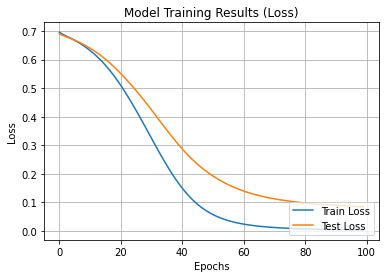

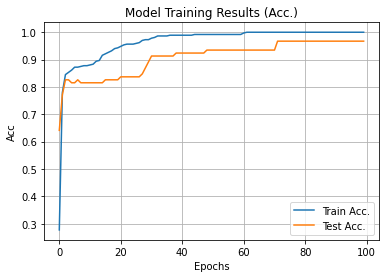

In [ ]:
""" Visualize Training Results """

##### Loss #####
# Get training results
history_dict = history.history
train_acc = history_dict['loss']
test_acc = history_dict['val_loss']

# Plot training results
plt.plot(train_acc, label='Train Loss')
plt.plot(test_acc, label='Test Loss')

# Show plot
plt.title('Model Training Results (Loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="lower right")
plt.grid()
plt.show()

##### Accuracy #####
# Get training results
history_dict = history.history
train_acc = history_dict['accuracy']
test_acc = history_dict['val_accuracy']

# Plot training results
plt.plot(train_acc, label='Train Acc.')
plt.plot(test_acc, label='Test Acc.')

# Show plot
plt.title('Model Training Results (Acc.)')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend(loc="lower right")
plt.grid()
plt.show()

#### ***Precision & Recall***

In [ ]:
""" Precision & Recall """

# Sklearn provides the classificatiaon_report(...) function which makes
# evaluation of classification model easy.
from sklearn.metrics import  classification_report

print(classification_report(
    np.argmax(y_test, axis=1),  # ground-truths
    np.argmax(model.predict(X_test), axis=1), # predictions
    target_names=CATEGORIES_TO_USE)
)

              precision    recall  f1-score   support

        left       0.93      0.96      0.95        27
     central       1.00      1.00      1.00        30
       right       0.97      0.94      0.96        35

    accuracy                           0.97        92
   macro avg       0.97      0.97      0.97        92
weighted avg       0.97      0.97      0.97        92

